In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [3]:
train=pd.read_csv('../1. Task and Data/train.csv',sep='|')
test=pd.read_csv('../1. Task and Data/test.csv',sep='|')

In [4]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


In [5]:
test

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  valuePerSecond  lineItemVoidsPerPosition
0                4                     467       88.48              4                         8                      4                   0.014989        0.189465                  0.571429
1                3                    1004       58.99              7                         6                      1                   0.026892        0.058755                  0.259259
2                1                     162       14.00              4                         5                      4                   0.006173        0.086420                  4.000000
3                5                     532       84.79              9                         3                      4                   0.026316        0.159380                  0.642857
4                5                     890       42.16              4                         0                      0                   0.021348        0.047371                  0.210526
5                5                    1072       12.67              3                         4                      1                   0.019590        0.011819                  0.142857
6                3                     259       93.75              0                         7                      0                   0.100386        0.361969                  0.000000
7                2                    1528       47.35              2                         9                      5                   0.009817        0.030988                  0.133333
8                6                     816       80.89              9                         4                      0                   0.017157        0.099130                  0.642857
9                4                      16       31.91              7                         7                      4                   1.312500        1.994375                  0.333333
10               3                     714       94.29              8                         7                      0                   0.016807        0.132059                  0.666667
11               5                    1077       66.16              5                         8                      3                   0.015785        0.061430                  0.294118
12               4                    1301       84.35              3                        10                      5                   0.021522        0.064835                  0.107143
13               3                    1429       47.95              8                         1                      3                   0.003499        0.033555                  1.600000
14               3                    1196       83.77             11                        10                      0                   0.004181        0.070042                  2.200000
15               3                    1567       75.53              7                        10                      1                   0.008296        0.048200                  0.538462
16               4                     289       18.66              8                         4                      0                   0.086505        0.064567                  0.320000
17               1                     335        1.19              0                         0                      1                   0.032836        0.003552                  0.000000
18               3                    1304       30.51              0                         7                      3                   0.012270        0.023397                  0.000000
19               5                    1353       82.02              0                         0                      2                   0.005174        0.060621                  0.000000
20               6                    1749       46.56      

# Feature Engineering

derived directly from given features

In [6]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

test['scannedLineItems'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['pricePerScannedLineItem'] = test['grandTotal'] / test['scannedLineItems']
test['scansWithoutRegistrationPerScannedLineItem'] = test['scansWithoutRegistration'] / test['scannedLineItems']
test['quantityModificationsPerScannedLineItem'] = test['quantityModifications'] / test['scannedLineItems']
test['lineItemVoidsPerSecond'] = test['lineItemVoids'] / test['totalScanTimeInSeconds']
test['scansWithoutRegistrationPerSecond'] = test['scansWithoutRegistration'] / test['totalScanTimeInSeconds']
test['quantityModificationsPerSecond'] = test['quantityModifications'] / test['totalScanTimeInSeconds']
test['secondsPerEuro'] = test['totalScanTimeInSeconds'] / test['grandTotal']
test['lineItemVoidsPerEuro'] = test['lineItemVoids'] / test['grandTotal']
test['scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / test['grandTotal']
test['quantityModificationsPerEuro'] = test['quantityModifications'] / test['grandTotal']

In [7]:
test.loc[test['grandTotal'] == 0.00, 'secondsPerEuro'] = test['totalScanTimeInSeconds'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'lineItemVoidsPerEuro'] = test['lineItemVoids'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'quantityModificationsPerEuro'] = test['quantityModifications'] / 0.01

derived from PCA / tSNE Analysis

In [8]:
test['fraud'] = -1

In [9]:
train_test_combined = pd.concat([train, test], ignore_index=True)

In [10]:
X_train_test_combined = train_test_combined.drop('fraud',axis=1)
Y_train_test_combined = train_test_combined['fraud']
print(X_train_test_combined.shape, Y_train_test_combined.shape)

(500000, 20) (500000,)


In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer 

feature_scaler = MinMaxScaler()
X_train_test_combined = pd.DataFrame(feature_scaler.fit_transform(X_train_test_combined.values), columns=X_train_test_combined.columns, index=X_train_test_combined.index)

#feature_scaler = StandardScaler()
#X = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
#data_preparation = "StandardScaler"

#transformer = FunctionTransformer(np.log1p, validate=True)
#X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
#data_preparation = "LogScaler"

derive features from PCA

In [12]:
from sklearn.decomposition import PCA

X_train_test_combined_PCA = X_train_test_combined.copy()

pca = PCA(n_components=7)
pca_result = pca.fit_transform(X_train_test_combined_PCA)

X_train_test_combined_PCA['pca-one'] = pca_result[:,0]
X_train_test_combined_PCA['pca-two'] = pca_result[:,1] 
X_train_test_combined_PCA['pca-three'] = pca_result[:,2]

X_train_test_combined_PCA['pca-one'] = pca_result[:,0]
X_train_test_combined_PCA['pca-two'] = pca_result[:,1] 
X_train_test_combined_PCA['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative explained variation for 7 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.16124041 0.1559011  0.14737624 0.13509126 0.13197732 0.11312753
 0.11161208]
Cumulative explained variation for 7 principal components: 0.9563259397521096


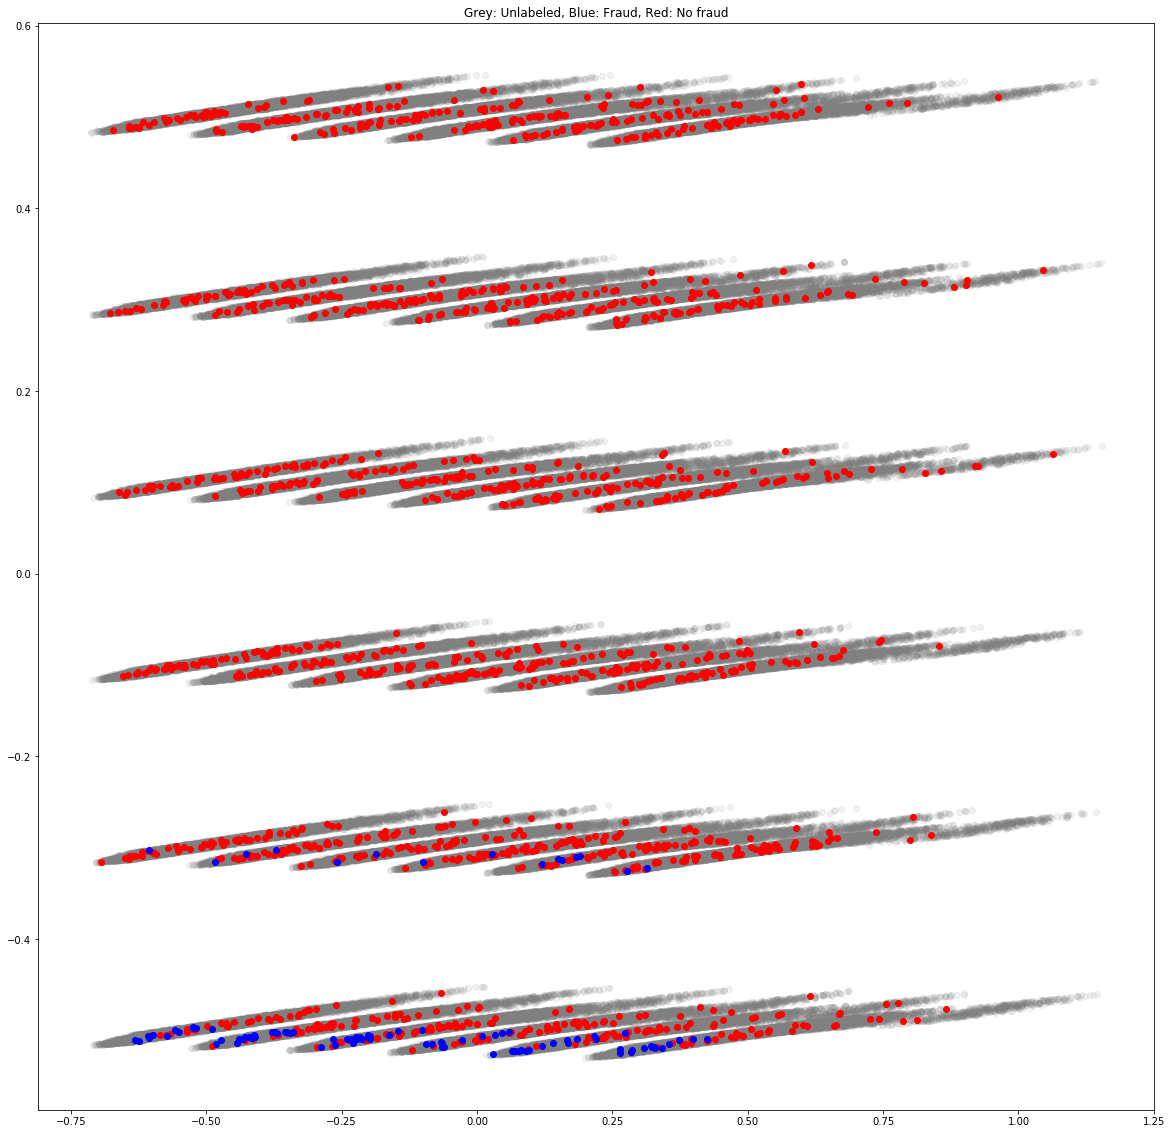

In [13]:
plt.rcParams['figure.figsize'] = (20,20)

plt.title('Grey: Unlabeled, Blue: Fraud, Red: No fraud')

plt.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == -1].values, X_train_test_combined_PCA["pca-two"][Y_train_test_combined == -1].values, color='grey', alpha = 0.1)
plt.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == 0], X_train_test_combined_PCA["pca-two"][Y_train_test_combined == 0], color='r')
plt.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == 1], X_train_test_combined_PCA["pca-two"][Y_train_test_combined == 1], color='b')
plt.show()

Add PCA axes as additional features

In [14]:
train['pca_axis_1'] = X_train_test_combined_PCA['pca-one'].head(len(train))
train['pca_axis_2'] = X_train_test_combined_PCA['pca-two'].head(len(train))

test['pca_axis_1'] = X_train_test_combined_PCA['pca-one'].tail(len(test)).reset_index(drop = True)
test['pca_axis_2'] = X_train_test_combined_PCA['pca-two'].tail(len(test)).reset_index(drop = True)

derive features from tSNE -> computation takes a long time -> use the precomputed value three cells below

In [15]:
X_train_test_combined_tSNE = X_train_test_combined.copy()

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300, init = 'pca')
tsne_results = tsne.fit_transform(X_train_test_combined_tSNE)

[t-SNE] Computing 91 nearest neighbors...


KeyboardInterrupt: 

In [16]:
# tsne_results_df = pd.DataFrame(tsne_results)
# tsne_results_df.to_pickle("tsneResult.pkl")
tsne_results = pd.read_pickle("tsneResult.pkl").values

In [17]:
X_train_test_combined_tSNE['tsne-one'] = tsne_results[:,0]
X_train_test_combined_tSNE['tsne-two'] = tsne_results[:,1]

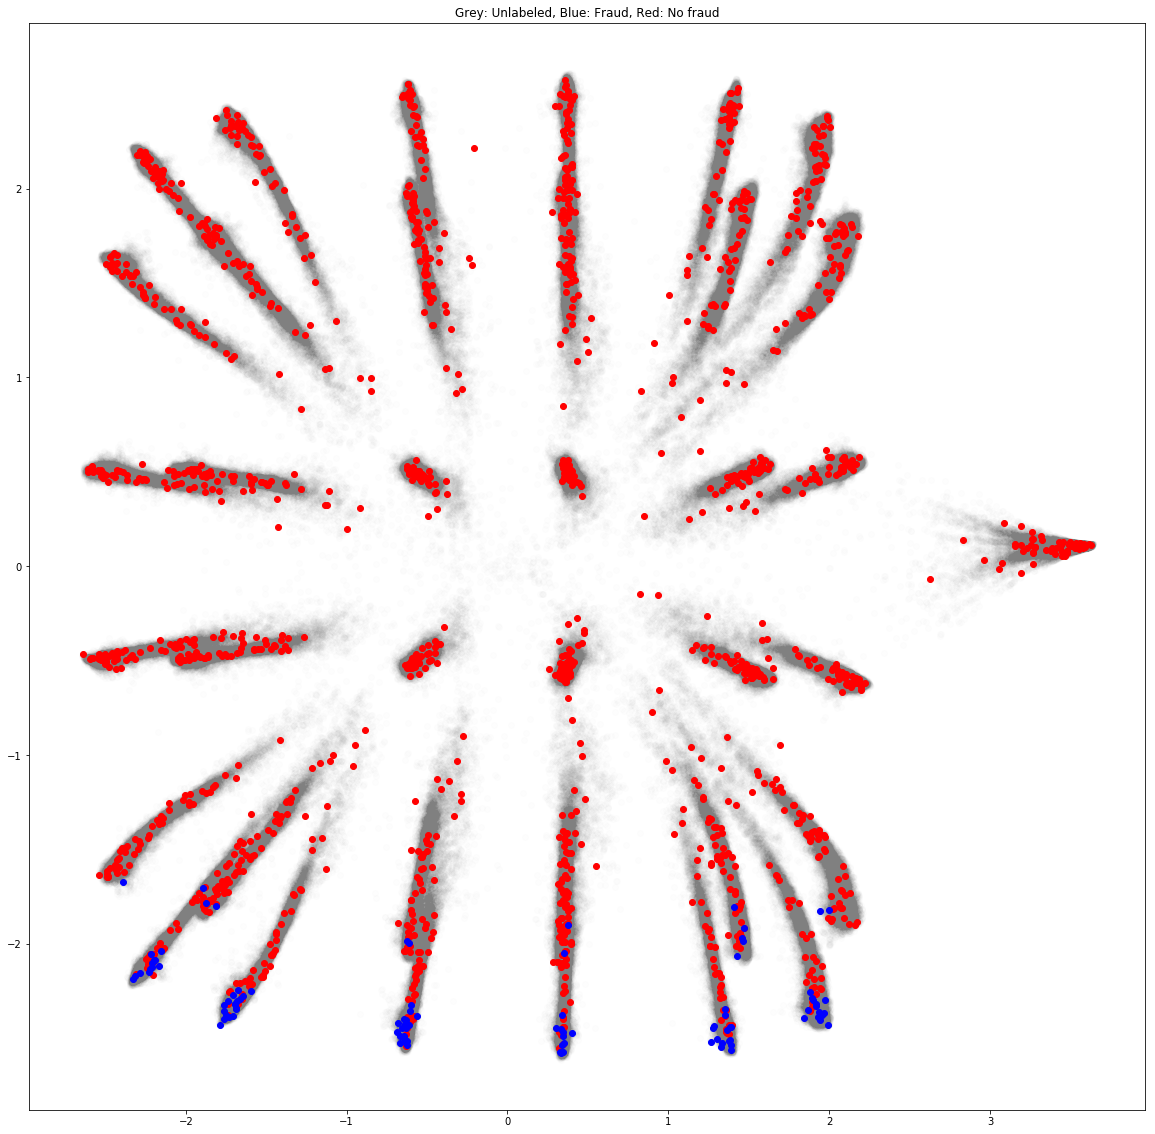

In [18]:
plt.rcParams['figure.figsize'] = (20,20)

plt.title('Grey: Unlabeled, Blue: Fraud, Red: No fraud')

plt.scatter(X_train_test_combined_tSNE["tsne-one"][Y_train_test_combined == -1].values, X_train_test_combined_tSNE["tsne-two"][Y_train_test_combined == -1].values, color='grey', alpha = 0.01)
plt.scatter(X_train_test_combined_tSNE["tsne-one"][Y_train_test_combined == 0], X_train_test_combined_tSNE["tsne-two"][Y_train_test_combined == 0], color='r')
plt.scatter(X_train_test_combined_tSNE["tsne-one"][Y_train_test_combined == 1], X_train_test_combined_tSNE["tsne-two"][Y_train_test_combined == 1], color='b')
plt.show()

In [19]:
train['tsne_axis_1'] = X_train_test_combined_tSNE['tsne-one'].head(len(train))
train['tsne_axis_2'] = X_train_test_combined_tSNE['tsne-two'].head(len(train))

test['tsne_axis_1'] = X_train_test_combined_tSNE['tsne-one'].tail(len(test)).reset_index(drop = True)
test['tsne_axis_2'] = X_train_test_combined_tSNE['tsne-two'].tail(len(test)).reset_index(drop = True)

In [20]:
test

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  valuePerSecond  lineItemVoidsPerPosition  scannedLineItems  pricePerScannedLineItem  scansWithoutRegistrationPerScannedLineItem  quantityModificationsPerScannedLineItem  lineItemVoidsPerSecond  scansWithoutRegistrationPerSecond  quantityModificationsPerSecond  secondsPerEuro  lineItemVoidsPerEuro  scansWithoutRegistrationPerEuro  quantityModificationsPerEuro  fraud  pca_axis_1  pca_axis_2  tsne_axis_1  tsne_axis_2
0                4                     467       88.48              4                         8                      4                   0.014989        0.189465                  0.571429               7.0                12.640000                                    1.142857                                 0.571429                0.008565                           0.017131                        0.008565        5.278029              0.045208                         0.090416                      0.045208     -1    0.407059    0.107610     1.288056     0.439125
1                3                    1004       58.99              7                         6                      1                   0.026892        0.058755                  0.259259              27.0                 2.184815                                    0.222222                                 0.037037                0.006972                           0.005976                        0.000996       17.019834              0.118664                         0.101712                      0.016952     -1   -0.404056   -0.107318    -2.048066    -0.496164
2                1                     162       14.00              4                         5                      4                   0.006173        0.086420                  4.000000               1.0                14.000000                                    5.000000                                 4.000000                0.024691                           0.030864                        0.024691       11.571429              0.285714                         0.357143                      0.285714     -1    0.648069   -0.481068     3.447044     0.053117
3                5                     532       84.79              9                         3                      4                   0.026316        0.159380                  0.642857              14.0                 6.056429                                    0.214286                                 0.285714                0.016917                           0.005639                        0.007519        6.274325              0.106145                         0.035382                      0.047175     -1    0.292492    0.294786     1.344228     1.554838
4                5                     890       42.16              4                         0                      0                   0.021348        0.047371                  0.210526              19.0                 2.218947                                    0.000000                                 0.000000                0.004494                           0.000000                        0.000000       21.110057              0.094877                         0.000000                      0.000000     -1   -0.564485    0.295128    -2.414502     1.547169
5                5                    1072       12.67              3                         4                      1                   0.019590        0.011819                  0.142857              21.0                 0.603333                                    0.190476                                 0.047619                0.002799                           0.003731                        0.000933       84.609313              0.236780                         0.315706                      0.078927     -1   -0.388592    0.294494    -1.828019     1.732591
6                3                     259       93.7

Find out center of clusters -> *this will not result in additional features as described below*

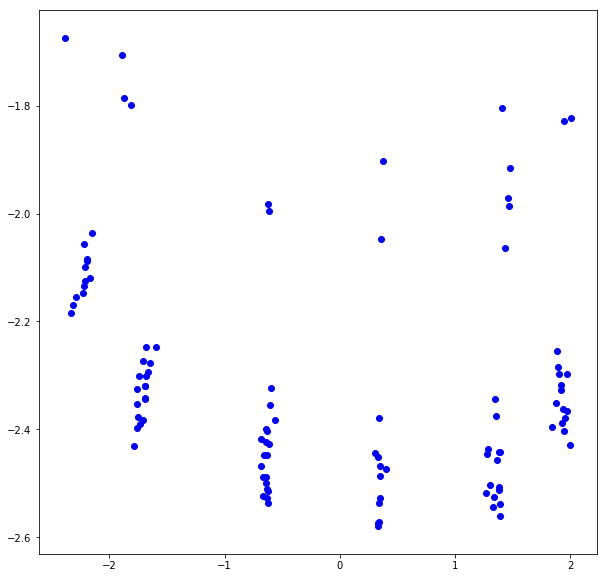

In [21]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(train['tsne_axis_1'][train['fraud'] == 1], train['tsne_axis_2'][train['fraud'] == 1], color='blue')

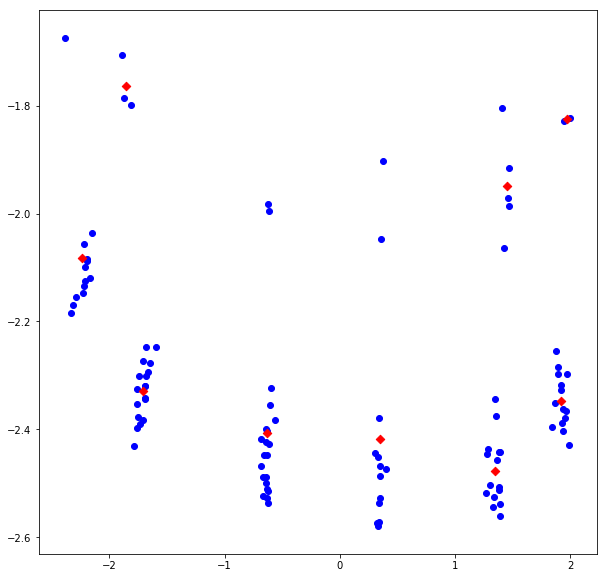

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 9)

combined_data = pd.DataFrame(train['tsne_axis_1'][train['fraud'] == 1])
combined_data['tsne_axis_2'] = train['tsne_axis_2'][train['fraud'] == 1]

kmeans.fit_predict(combined_data)

plt.scatter(train['tsne_axis_1'][train['fraud'] == 1], train['tsne_axis_2'][train['fraud'] == 1], color='blue')

cluster_centers = kmeans.cluster_centers_

plt.scatter(cluster_centers[:,0], cluster_centers[:,1], color='red', marker = "D")

Distance to cluster centers

In [23]:
def dist(points1, points2):
    result = []
    for i in range(0, len(points1)):
        result.append(np.sqrt( (points1['tsne_axis_1'][i] - points2['tsne_axis_1'][i])**2
                              +(points1['tsne_axis_2'][i] - points2['tsne_axis_2'][i])**2))
    return(result)

In [24]:
coordinates = pd.DataFrame(
            {'tsne_axis_1': train['tsne_axis_1'],
             'tsne_axis_2': train['tsne_axis_2'],
            })
coordinates['tsne_axis_1']

cluster_center_1 = pd.DataFrame([cluster_centers[0]] * len(train))
cluster_center_2 = pd.DataFrame([cluster_centers[1]] * len(train))
cluster_center_3 = pd.DataFrame([cluster_centers[2]] * len(train))
cluster_center_4 = pd.DataFrame([cluster_centers[0]] * len(train))
cluster_center_5 = pd.DataFrame([cluster_centers[1]] * len(train))
cluster_center_6 = pd.DataFrame([cluster_centers[2]] * len(train))
cluster_center_7 = pd.DataFrame([cluster_centers[0]] * len(train))
cluster_center_8 = pd.DataFrame([cluster_centers[1]] * len(train))
cluster_center_9 = pd.DataFrame([cluster_centers[2]] * len(train))

cluster_center_1.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_2.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_3.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_4.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_5.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_6.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_7.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_8.columns = ['tsne_axis_1', 'tsne_axis_2']
cluster_center_9.columns = ['tsne_axis_1', 'tsne_axis_2']

# don't use distance to cluster centers because it 'does not preserve distances nor density' (https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne)

#train['distance_cluster_center_1'] = dist(cluster_center_1, coordinates)
#train['distance_cluster_center_2'] = dist(cluster_center_2, coordinates)
#train['distance_cluster_center_3'] = dist(cluster_center_3, coordinates)
#train['distance_cluster_center_4'] = dist(cluster_center_4, coordinates)
#train['distance_cluster_center_5'] = dist(cluster_center_5, coordinates)
#train['distance_cluster_center_6'] = dist(cluster_center_6, coordinates)
#train['distance_cluster_center_7'] = dist(cluster_center_7, coordinates)
#train['distance_cluster_center_8'] = dist(cluster_center_8, coordinates)
#train['distance_cluster_center_9'] = dist(cluster_center_9, coordinates)

Remove the fraud label from the test data again

In [25]:
test = test.drop('fraud',axis=1)

# Feature Importance Analysis

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

y = train['fraud']
x = train.drop('fraud',axis=1)

# feature extraction
model = ExtraTreesClassifier(criterion = 'entropy')
model.fit(x, y)

pd.DataFrame(model.feature_importances_, list(x), columns =['Importance']).sort_values(by='Importance', ascending = False)

Importance
scannedLineItems                              0.180354
tsne_axis_2                                   0.178937
pca_axis_2                                    0.167404
trustLevel                                    0.095652
totalScanTimeInSeconds                        0.033493
scansWithoutRegistration                      0.031009
lineItemVoidsPerPosition                      0.030767
quantityModificationsPerScannedLineItem       0.025244
scansWithoutRegistrationPerScannedLineItem    0.022414
scannedLineItemsPerSecond                     0.022354
pca_axis_1                                    0.021443
lineItemVoids                                 0.019468
quantityModifications                         0.017270
tsne_axis_1                                   0.017152
pricePerScannedLineItem                       0.016750
quantityModificationsPerSecond                0.016347
lineItemVoidsPerSecond                        0.014913
grandTotal                                    0.014594
valuePerSecond                                0.014227
quantityModificationsPerEuro                  0.013680
lineItemVoidsPerEuro                          0.012611
secondsPerEuro                                0.012466
scansWithoutRegistrationPerSecond             0.011547
scansWithoutRegistrationPerEuro               0.009904

# Defining different oversampling strategies

- Classical Oversampling
- SMOTE Technique
- ADASYN Technique

Each one has a slightly different approach for generating synthetic instances
- Simply duplicated fraud instances
- ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier
- SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule.


In [23]:
# !pip install imblearn  # might be necessary for installation
from imblearn.over_sampling import RandomOverSampler

def randomOverSampling(train):
    ros = RandomOverSampler(random_state=42, ratio = 1)
    X_train_extended, Y_train_extended = ros.fit_resample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train["fraud"] = Y_train_extended
    return new_train

print(randomOverSampling(train).fraud.value_counts())
print(randomOverSampling(train).fraud.value_counts() / len(randomOverSampling(train)))

1    1775
0    1775
Name: fraud, dtype: int64
1    0.5
0    0.5
Name: fraud, dtype: float64


In [24]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE

def smoteOverSamling(train):
    sm = SMOTE(random_state=42, k_neighbors = 3, ratio = 1)
    X_train_extended, Y_train_extended = sm.fit_sample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train ["fraud"] = Y_train_extended
    return new_train
    
print(smoteOverSamling(train).fraud.value_counts())
print(smoteOverSamling(train).fraud.value_counts() / len(smoteOverSamling(train)))

1    1775
0    1775
Name: fraud, dtype: int64
1    0.5
0    0.5
Name: fraud, dtype: float64


In [25]:
from imblearn.over_sampling import ADASYN

def adasynOverSamling(train):
    ada = ADASYN(random_state=42, n_neighbors = 3, ratio = 1)
    X_train_extended, Y_train_extended = ada.fit_resample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train["fraud"] = Y_train_extended
    return new_train
    
print(adasynOverSamling(train).fraud.value_counts())
print(adasynOverSamling(train).fraud.value_counts() / len(adasynOverSamling(train)))

1    1820
0    1775
Name: fraud, dtype: int64
1    0.506259
0    0.493741
Name: fraud, dtype: float64


# Defining the Custom Score Function based on the given cost matrix

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

# Building model factory

In [169]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import Perceptron
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



model_tuning_factory = [   
    GridSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                      fit_intercept = [True, False],
                      C = np.arange(0.1, 2.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(KNeighborsClassifier(), 
                 dict(
                     n_neighbors = [1, 3, 5, 10, 15],
                     weights = ['uniform', 'distance'],
                     p = [1, 2, 3]
                 ),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
#    GridSearchCV(NearestCentroid(),     # cause some problems
#                 dict(metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'mahalanobis']),
#                 cv = skf,
#                 scoring = my_custom_score,
#                 refit = True,
#                  n_jobs = -1),
    GridSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      splitter = ['best', 'random'],
                      max_depth = range(1,50,2),
                      min_samples_split = range(2,10,2)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      splitter = ['best', 'random'],
                      max_depth = range(1,50,2),
                      min_samples_split = range(2,10,2)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(ExtraTreesClassifier(),
                 dict(n_estimators = range(5,200,5),
                      criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),    
    GridSearchCV(RandomForestClassifier(),
                 dict(n_estimators = range(5,200,5),
                      criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),    
    GridSearchCV(BernoulliNB(),
                 dict(binarize  = [0.0, 0.2, 0.5, 1, 2],
                      alpha = [0, 0.2, 0.5, 1, 2]),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),     
    GridSearchCV(GaussianNB(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),     
    GridSearchCV(GradientBoostingClassifier(),
                 dict(loss = ['deviance', 'exponential'],
                      n_estimators = [20, 50,100, 150, 200]),
                 #dict(n_estimators = range(1,150)),
                 #     learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(AdaBoostClassifier(),
                 dict(n_estimators = [20, 50,100, 150, 200],
                      algorithm = ['SAMME', 'SAMME.R'],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None] # default
                      ),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
    GridSearchCV(XGBClassifier(),
                 dict(objective = ['binary:logistic'],
                      eval_metric = ['error'],
                      base_score = [0.3, 0.5, 0.7],
                      learning_rate = [0.01, 0.1, 0.2, 0.3],
                      n_estimators = [10, 20, 50, 100]),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(XGBClassifier(),
                 dict(objective = ['binary:logistic'],
                      eval_metric = ['error'],
                   #   base_score = [0.3, 0.5, 0.7],
                   #   learning_rate = [0.01, 0.1, 0.2, 0.3],
                      n_estimators = [10, 20, 50, 100],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting for AdaBoost
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None]),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(BaggingClassifier(), 
                 dict(n_estimators = [5, 10, 20, 50, 100, 150, 200],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting for AdaBoost
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None]),   # standard -> 'Decision Tree'
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
    GridSearchCV(Perceptron(),
                 dict(penalty = ['l2', 'l1', 'elasticnet', None],
                      alpha = np.arange(0.0005, 0.001, 0.0005),
                      fit_intercept = [True, False],
                      max_iter = range(5,100,5)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
    GridSearchCV(MLPClassifier(),
                 dict(solver = ['lbfgs', 'sgd', 'adam'],
                      activation = ['identity', 'logistic', 'tanh', 'relu'],
                      learning_rate = ['constant', 'invscaling', 'adaptive']),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
#    GridSearchCV(LinearDiscriminantAnalysis(),                       # tsne dimensions cause problems
#                 dict(solver  = ['svd', 'lsqr', 'eigen'],
#                      n_components = range(1,20)),
#                 cv = skf,
#                 scoring = my_custom_score,
#                 refit = True,
#                 n_jobs = -1),
    GridSearchCV(QuadraticDiscriminantAnalysis(),
                 dict(reg_param = np.arange(0.1, 1.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(SVC(),                                           # gets very slow at some point
                 dict(C = [0.01, 0.1, 0.5, 1, 2]),
                  cv = skf,
                  scoring = my_custom_score,
                  refit = True,
                  n_jobs = -1)
]       


model_tuning_factory_temp = [

]

In [170]:
import time
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from math import log

result_table = pd.DataFrame(columns=["Model", "Oversampling Strategy", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model", 'Cross Validation Results'])

for oversampling_strategy in range(1,2):  # Oversamling strategies currtently not in the loop
    if (oversampling_strategy == 1):  
        Y = train['fraud']
        X = train.drop('fraud',axis=1)
        oversampling = "No Oversampling"
    elif (oversampling_strategy == 2):
        extended_train = randomOverSampling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "Random Oversampling"
    elif (oversampling_strategy == 3):
        extended_train = smoteOverSamling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "SMOTE"
    elif (oversampling_strategy == 3):
        extended_train = adasynOverSamling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "Adaysin"
            
    # four types of data preparation: No preparation, MaxMinScaler, StandardScaler, LogScaling
    for data_preparation_strategy in range(1,5):
        if (data_preparation_strategy == 1):  
            X_scaled = X
            data_preparation = "No Scaling"
        elif (data_preparation_strategy == 2):
            feature_scaler = MinMaxScaler()  
            X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
            data_preparation = "MinMaxScaler"
        elif (data_preparation_strategy == 3):
            feature_scaler = StandardScaler()  
            X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
            data_preparation = "StandardScaler"
        elif (data_preparation_strategy == 4):
            transformer = FunctionTransformer(np.log1p, validate=True)  
            
            # pca and tsne feature cause an error -> therefore no log scaling            
            X_scaled = pd.DataFrame(transformer.transform(X.iloc[:, range(0,20)]), columns=X.iloc[:, range(0,20)].columns, index=X.iloc[:, range(0,20)].index)
            
            X_scaled['pca_axis_1'] = X['pca_axis_1']
            X_scaled['pca_axis_2'] = X['pca_axis_2']
            X_scaled['tsne_axis_1'] = X['tsne_axis_1']
            X_scaled['tsne_axis_2'] = X['tsne_axis_2']

            data_preparation = "LogScaler"    



        for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results

                
            for feature_count in range(1,len(list(X))+1):
   
                random.seed = 42
                model.seed = 42
                start_time = time.time()              
                
                
                # Solution with SelectKBest
                best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
                best_feature_list = X.columns[best_features.get_support()]
                X_selected_features = X[best_feature_list]
                
                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]
                cross_validation_results = model.cv_results_
                
                result_table = result_table.append({
                 "Model": model_name,
                 "Oversampling Strategy": oversampling,   
                 "Data Preparation": data_preparation,   
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "SelectKBest",   
                 "Features": best_feature_list.values, 
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,   
                 "Raw Model": model.best_estimator_,
                 "Cross Validation Results": cross_validation_results
                  }, ignore_index=True)
                

                # Solution with Recursive Feature Elimination -> only works for some models
                
                if (model.estimator.__class__.__name__ == 'LogisticRegression'
                 or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
                 or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
                 or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
                 or model.estimator.__class__.__name__ == 'RandomForestClassifier'
                 or model.estimator.__class__.__name__ == 'BernoulliNB'
                 or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
                 or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
                 or model.estimator.__class__.__name__ == 'XGBClassifier'    
                 or model.estimator.__class__.__name__ == 'Perceptron'
                 or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):
                
                   # Traditional RFE
                    rfe = RFE(model.estimator, n_features_to_select = feature_count)
                    rfe = rfe.fit(X,Y)
                    best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                    X_selected_features = X[best_feature_list]

                    model.fit(X_selected_features,Y)  
                    model_name = model.best_estimator_.__class__.__name__
                    score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                    score_std = model.cv_results_['std_test_score'][model.best_index_]
                    cross_validation_results = model.cv_results_


                    result_table = result_table.append({
                     "Model": model_name,
                     "Oversampling Strategy": oversampling,   
                     "Data Preparation": data_preparation,
                     "Feature Count": feature_count,
                     "Feature Selection Technique": "RFE",
                     "Features": best_feature_list,
                     "Optimal Parameters": model.best_params_,
                     "Monetary Value Per Instance - Mean":  score_mean,
                     "Monetary Value Per Instance - Standard Deviation": score_std,  
                     "Raw Model": model.best_estimator_,
                     "Cross Validation Results": cross_validation_results
                      }, ignore_index=True)
                    
                end_time = time.time()

                print("Finished " + model.best_estimator_.__class__.__name__ + " with " + oversampling + " and " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")

                 
                
            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'XGBClassifier'    
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

                # RFE with Cross Validation -> determines the optimum feature count automatically
                rfecv = RFECV(model.estimator, cv = skf)
                rfecv = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]
                cross_validation_results = model.cv_results_

                result_table = result_table.append({
                 "Model": model_name,
                 "Oversampling Strategy": oversampling,   
                 "Data Preparation": data_preparation,
                 "Feature Count": len(best_feature_list),
                 "Feature Selection Technique": "RFECV",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,    
                 "Raw Model": model.best_estimator_,
                 "Cross Validation Results": cross_validation_results
                  }, ignore_index=True)
                    
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished LogisticRegression with No Oversampling and No Scaling and 1 features after 3.52 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 2 features after 1.87 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 3 features after 2.22 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 4 features after 2.59 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 5 features after 13.36 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 6 features after 11.94 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 7 features after 10.26 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 8 features after 12.3 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 9 features after 11.12 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 10 features after 16.52 seconds
Finished Logis

Finished ExtraTreeClassifier with No Oversampling and No Scaling and 11 features after 9.1 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 12 features after 9.62 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 13 features after 6.95 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 14 features after 9.2 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 15 features after 10.04 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 16 features after 9.64 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 17 features after 10.37 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 18 features after 9.46 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 19 features after 9.83 seconds
Finished ExtraTreeClassifier with No Oversampling and No Scaling and 20 features after 9.89 seconds


Finished BernoulliNB with No Oversampling and No Scaling and 22 features after 1.43 seconds
Finished BernoulliNB with No Oversampling and No Scaling and 23 features after 1.84 seconds
Finished BernoulliNB with No Oversampling and No Scaling and 24 features after 1.77 seconds
Finished GaussianNB with No Oversampling and No Scaling and 1 features after 0.04 seconds
Finished GaussianNB with No Oversampling and No Scaling and 2 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 3 features after 0.06 seconds
Finished GaussianNB with No Oversampling and No Scaling and 4 features after 0.05 seconds
Finished GaussianNB with No Oversampling and No Scaling and 5 features after 0.04 seconds
Finished GaussianNB with No Oversampling and No Scaling and 6 features after 0.04 seconds
Finished GaussianNB with No Oversampling and No Scaling and 7 features after 0.03 seconds
Finished GaussianNB with No Oversampling and No Scaling and 8 features after 0.04 seconds
Fini

Finished XGBClassifier with No Oversampling and No Scaling and 10 features after 34.43 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 11 features after 38.53 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 12 features after 37.21 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 13 features after 37.26 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 14 features after 35.07 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 15 features after 35.91 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 16 features after 37.64 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 17 features after 26.01 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 18 features after 33.01 seconds
Finished XGBClassifier with No Oversampling and No Scaling and 19 features after 27.82 seconds
Finished XGBClassifier with No Oversampling and No

Finished MLPClassifier with No Oversampling and No Scaling and 1 features after 37.09 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 2 features after 45.17 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 3 features after 48.2 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 4 features after 45.98 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 5 features after 32.88 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 6 features after 32.47 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 7 features after 35.18 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 8 features after 35.31 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 9 features after 38.72 seconds
Finished MLPClassifier with No Oversampling and No Scaling and 10 features after 39.35 seconds
Finished MLPClassifier with No Oversampling and No Scaling a

Finished LogisticRegression with No Oversampling and MinMaxScaler and 14 features after 26.05 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 15 features after 33.91 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 16 features after 27.43 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 17 features after 24.18 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 18 features after 25.47 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 19 features after 28.29 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 20 features after 45.29 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 21 features after 64.23 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 22 features after 68.7 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 23 features a

Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 22 features after 8.08 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 23 features after 7.07 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 24 features after 6.71 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 1 features after 16.67 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 2 features after 16.72 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 3 features after 16.72 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 4 features after 19.05 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 5 features after 16.74 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 6 features after 17.84 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 7 fe

Finished GaussianNB with No Oversampling and MinMaxScaler and 9 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 10 features after 0.04 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 11 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 12 features after 0.06 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 13 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 14 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 15 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 16 features after 0.04 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 17 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 18 features after 0.05 seconds
Finished GaussianNB with No Oversampling and MinMaxScaler and 19 featur

Finished XGBClassifier with No Oversampling and MinMaxScaler and 19 features after 18.85 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 20 features after 18.24 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 21 features after 18.06 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 22 features after 18.02 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 23 features after 17.77 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 24 features after 17.46 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 1 features after 15.35 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 2 features after 12.43 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 3 features after 11.83 seconds
Finished XGBClassifier with No Oversampling and MinMaxScaler and 4 features after 15.22 seconds
Finished XGBClassifier with No Ove

Finished MLPClassifier with No Oversampling and MinMaxScaler and 8 features after 31.77 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 9 features after 25.88 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 10 features after 30.19 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 11 features after 28.44 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 12 features after 27.49 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 13 features after 26.89 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 14 features after 27.09 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 15 features after 28.02 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 16 features after 27.39 seconds
Finished MLPClassifier with No Oversampling and MinMaxScaler and 17 features after 26.85 seconds
Finished MLPClassifier with No O

Finished LogisticRegression with No Oversampling and StandardScaler and 19 features after 18.84 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 20 features after 28.87 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 21 features after 26.47 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 22 features after 31.65 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 23 features after 46.8 seconds
Finished LogisticRegression with No Oversampling and StandardScaler and 24 features after 55.95 seconds
Finished KNeighborsClassifier with No Oversampling and StandardScaler and 1 features after 1.06 seconds
Finished KNeighborsClassifier with No Oversampling and StandardScaler and 2 features after 1.07 seconds
Finished KNeighborsClassifier with No Oversampling and StandardScaler and 3 features after 1.61 seconds
Finished KNeighborsClassifier with No Oversampling and StandardSc

Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 2 features after 18.06 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 3 features after 15.85 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 4 features after 17.5 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 5 features after 16.59 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 6 features after 21.02 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 7 features after 16.76 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 8 features after 19.92 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 9 features after 23.59 seconds
Finished ExtraTreesClassifier with No Oversampling and StandardScaler and 10 features after 24.68 seconds
Finished ExtraTreesClassifier with No Oversampling and 

Finished GaussianNB with No Oversampling and StandardScaler and 11 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 12 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 13 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 14 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 15 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 16 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 17 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 18 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 19 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 20 features after 0.03 seconds
Finished GaussianNB with No Oversampling and Stand

Finished XGBClassifier with No Oversampling and StandardScaler and 19 features after 25.11 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 20 features after 28.56 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 21 features after 29.64 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 22 features after 26.64 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 23 features after 27.42 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 24 features after 29.75 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 1 features after 15.65 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 2 features after 15.41 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 3 features after 15.67 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 4 features after 14.73 seconds
Finished XGBCl

Finished MLPClassifier with No Oversampling and StandardScaler and 7 features after 21.81 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 8 features after 24.73 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 9 features after 23.09 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 10 features after 22.52 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 11 features after 21.85 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 12 features after 29.23 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 13 features after 22.93 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 14 features after 23.92 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 15 features after 29.03 seconds
Finished MLPClassifier with No Oversampling and StandardScaler and 16 features after 25.26 seconds
Finished MLPC

Finished LogisticRegression with No Oversampling and LogScaler and 18 features after 44.14 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 19 features after 44.49 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 20 features after 49.3 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 21 features after 51.2 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 22 features after 44.86 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 23 features after 80.77 seconds
Finished LogisticRegression with No Oversampling and LogScaler and 24 features after 95.06 seconds
Finished KNeighborsClassifier with No Oversampling and LogScaler and 1 features after 1.12 seconds
Finished KNeighborsClassifier with No Oversampling and LogScaler and 2 features after 1.15 seconds
Finished KNeighborsClassifier with No Oversampling and LogScaler and 3 features after 2.06 seconds
Finished KNe

Finished ExtraTreesClassifier with No Oversampling and LogScaler and 5 features after 16.98 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 6 features after 18.7 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 7 features after 17.12 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 8 features after 18.4 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 9 features after 19.26 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 10 features after 17.74 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 11 features after 18.39 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 12 features after 17.67 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 13 features after 18.82 seconds
Finished ExtraTreesClassifier with No Oversampling and LogScaler and 14 features after 18.35 secon

Finished GaussianNB with No Oversampling and LogScaler and 19 features after 0.06 seconds
Finished GaussianNB with No Oversampling and LogScaler and 20 features after 0.06 seconds
Finished GaussianNB with No Oversampling and LogScaler and 21 features after 0.06 seconds
Finished GaussianNB with No Oversampling and LogScaler and 22 features after 0.06 seconds
Finished GaussianNB with No Oversampling and LogScaler and 23 features after 0.06 seconds
Finished GaussianNB with No Oversampling and LogScaler and 24 features after 0.06 seconds
Finished GradientBoostingClassifier with No Oversampling and LogScaler and 1 features after 8.1 seconds
Finished GradientBoostingClassifier with No Oversampling and LogScaler and 2 features after 6.23 seconds
Finished GradientBoostingClassifier with No Oversampling and LogScaler and 3 features after 5.51 seconds
Finished GradientBoostingClassifier with No Oversampling and LogScaler and 4 features after 10.07 seconds
Finished GradientBoostingClassifier with

Finished XGBClassifier with No Oversampling and LogScaler and 7 features after 11.58 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 8 features after 11.32 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 9 features after 11.39 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 10 features after 11.41 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 11 features after 11.27 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 12 features after 11.07 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 13 features after 11.06 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 14 features after 10.99 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 15 features after 10.85 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 16 features after 10.6 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 17

Finished MLPClassifier with No Oversampling and LogScaler and 23 features after 24.84 seconds
Finished MLPClassifier with No Oversampling and LogScaler and 24 features after 25.65 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 1 features after 0.26 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 2 features after 0.23 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 3 features after 0.24 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 4 features after 0.26 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 5 features after 0.23 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 6 features after 0.26 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 7 features after 0.23 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampl

Model Oversampling Strategy Data Preparation Feature Count Feature Selection Technique                                           Features                                 Optimal Parameters  Monetary Value Per Instance - Mean  Monetary Value Per Instance - Standard Deviation                                          Raw Model                           Cross Validation Results
414              AdaBoostClassifier       No Oversampling       No Scaling            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05056438446044922, 0.1769...
1095             AdaBoostClassifier       No Oversampling     MinMaxScaler            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05425493717193604, 0.2058...
2461             AdaBoostClassifier       No Oversampling        LogScaler            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.0544543981552124, 0.20874...
1778             AdaBoostClassifier       No Oversampling   StandardScaler            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05784509181976318, 0.1759...
1097             AdaBoostClassifier       No Oversampling     MinMaxScaler            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05764601230621338, 0.2370...
1780             AdaBoostClassifier       No Oversampling   StandardScaler            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.04896423816680908, 0.1266...
412              AdaBoostClassifier       No Oversampling       No Scaling            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05176126956939697, 0.1792...
2463             AdaBoostClassifier       No Oversampling        LogScaler            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.04527671337127685, 0.1219...
1115             AdaBoostClassifier       No Oversampling     MinMaxScaler            21                         RFE  [totalScanTimeInSeconds, grandTotal, lineItemV...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.188930                                          0.056780  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit

# Restore the saved result table to avoid recomputation

# The results of this workflow are merged with the result of the workflow without the additional PCA and tSNE features as some models performed worse with this larger feature set while others performed better

In [28]:
# result_table.to_pickle("Automated Workflow Results with PCA and tSNEpkl")
result_table = pd.read_pickle("Automated Workflow Results with PCA and tSNE.pkl")
result_table2 = pd.read_pickle("Automated Workflow Results.pkl")

result_table = pd.concat([result_table, result_table2], ignore_index=True)

In [29]:
result_table = result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)
result_table.to_excel("Automated Workflow Results.xlsx")
result_table

Model Oversampling Strategy Data Preparation Feature Count Feature Selection Technique                                           Features                                 Optimal Parameters  Monetary Value Per Instance - Mean  Monetary Value Per Instance - Standard Deviation                                          Raw Model                           Cross Validation Results
1778             AdaBoostClassifier       No Oversampling   StandardScaler            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05784509181976318, 0.1759...
1780             AdaBoostClassifier       No Oversampling   StandardScaler            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.04896423816680908, 0.1266...
414              AdaBoostClassifier       No Oversampling       No Scaling            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05056438446044922, 0.1769...
412              AdaBoostClassifier       No Oversampling       No Scaling            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05176126956939697, 0.1792...
1095             AdaBoostClassifier       No Oversampling     MinMaxScaler            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05425493717193604, 0.2058...
2463             AdaBoostClassifier       No Oversampling        LogScaler            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.04527671337127685, 0.1219...
2461             AdaBoostClassifier       No Oversampling        LogScaler            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.0544543981552124, 0.20874...
1097             AdaBoostClassifier       No Oversampling     MinMaxScaler            12                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit_time': [0.05764601230621338, 0.2370...
1115             AdaBoostClassifier       No Oversampling     MinMaxScaler            21                         RFE  [totalScanTimeInSeconds, grandTotal, lineItemV...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.188930                                          0.056780  (DecisionTreeClassifier(class_weight=None, cri...  {'mean_fit

In [30]:
# to prefer no scaling in case of the same computed value for the sorting
result_table["Data Preparation Technique"] = -1
result_table.loc[result_table["Data Preparation"] == "No Scaling" , "Data Preparation Technique"] = 4
result_table.loc[result_table["Data Preparation"] == "MinMaxScaler", "Data Preparation Technique"] = 3
result_table.loc[result_table["Data Preparation"] == "StandardScaler", "Data Preparation Technique"] = 3
result_table.loc[result_table["Data Preparation"] == "LogScaler", "Data Preparation Technique"] = 1

# to prefer a lower feature score in case of the same metric score for the sorting
result_table["Inverse Feature Count"] = 1 / result_table["Feature Count"]


result_table = result_table.sort_values(by = ["Monetary Value Per Instance - Mean", "Data Preparation Technique", "Inverse Feature Count"], ascending = False)

# Aggregated Result Table

In [31]:
result_table_aggregated = pd.DataFrame(columns=["Model", "Oversampling Strategy", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


for model in list(set(result_table["Model"].values)):
    sub_table = result_table[result_table["Model"] == model]
    result_table_aggregated = result_table_aggregated.append({
        "Model": model,
        "Oversampling Strategy": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Oversampling Strategy"],
        "Data Preparation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Data Preparation"],
        "Feature Count": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Count"],
        "Features": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Features"],
        "Feature Selection Technique": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Selection Technique"],
        "Optimal Parameters": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"],
        "Monetary Value Per Instance - Mean": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Mean"],
        "Monetary Value Per Instance - Standard Deviation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Standard Deviation"],
        "Raw Model": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
        }, ignore_index=True)

result_table_aggregated.to_excel("Automated Workflow Results Aggregated.xlsx")


result_table_aggregated.sort_values(by = ["Monetary Value Per Instance - Mean"], ascending = False)

Model Oversampling Strategy Data Preparation Feature Count Feature Selection Technique                                           Features                                 Optimal Parameters  Monetary Value Per Instance - Mean  Monetary Value Per Instance - Standard Deviation                                          Raw Model
12             AdaBoostClassifier       No Oversampling       No Scaling            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...
3                   XGBClassifier       No Oversampling       No Scaling            22                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'base_score': 0.5, 'eval_metric': 'error', 'l...                            0.175625                                          0.108912  XGBClassifier(base_score=0.5, booster='gbtree'...
4              LogisticRegression       No Oversampling       No Scaling             9                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'C': 1.2000000000000002, 'fit_intercept': Tru...                            0.167642                                          0.118947  LogisticRegression(C=1.2000000000000002, class...
2            ExtraTreesClassifier       No Oversampling       No Scaling             8                         RFE  [trustLevel, totalScanTimeInSeconds, lineItemV...      {'criterion': 'entropy', 'n_estimators': 140}                            0.146354                                          0.077010  (ExtraTreeClassifier(class_weight=None, criter...
5      GradientBoostingClassifier       No Oversampling       No Scaling            10                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...          {'loss': 'deviance', 'n_estimators': 150}                            0.143693                                          0.101174  ([DecisionTreeRegressor(criterion='friedman_ms...
15              BaggingClassifier       No Oversampling       No Scaling            14                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'base_estimator': LogisticRegression(C=1.0, c...                            0.138371                                          0.091208  (LogisticRegression(C=1.0, class_weight=None, ...
6          RandomForestClassifier       No Oversampling   StandardScaler            10                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...      {'criterion': 'entropy', 'n_estimators': 105}                            0.101118                                          0.089369  (DecisionTreeClassifier(class_weight=None, cri...
11         DecisionTreeClassifier       No Oversampling     MinMaxScaler            14                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'criterion': 'gini', 'max_depth': 35, 'min_sa...                            0.085152                                          0.094774  DecisionTreeClassifier(class_weight=None, crit...
14                  MLPClassifier       No Oversampling   StandardScaler            20                 SelectKBest  [trustLevel, totalScanTimeInSeconds, grandTota...  {'activation': 'logistic', 'learning_rate': 'c...                            0.077169                                          0.071634  MLPClassifier(activation='logistic', alpha=0.0...
8             ExtraTreeClassifier       No Oversampling        LogScaler             5                         RFE  [totalScanTimeInSeconds, scansWithoutRegistrat...  {'criterion': 'gini', 'max_depth': 21, 'min_sa...                            0.055881                                          0.115128  ExtraTreeClassifier(class_weight=None, criteri...
0                      GaussianNB       No Oversampling       No Scaling             3                 SelectKBest  [trustLevel, total

# Selection of the Final Model

# Option 1: Just use the best performing model for prediction

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

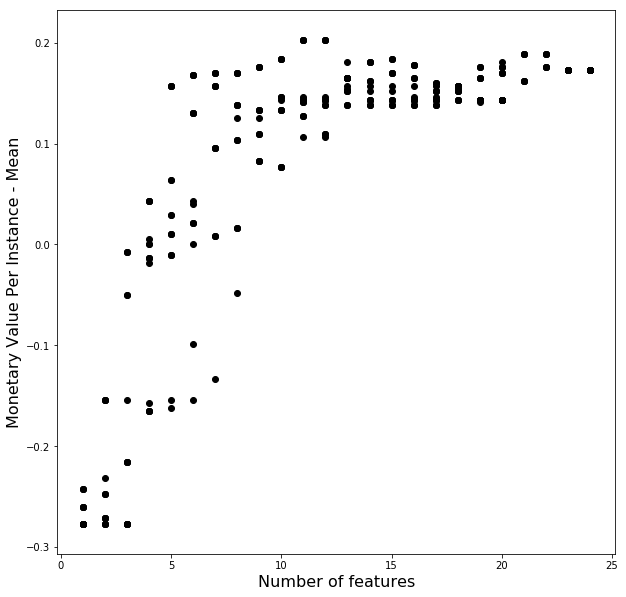

In [32]:
plt.rcParams['figure.figsize'] = (10,10)


sub_table = result_table[result_table["Model"] == "AdaBoostClassifier"]



plt.scatter(sub_table["Feature Count"],
            sub_table["Monetary Value Per Instance - Mean"],
             c = 'black'),


plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

#ggplot(aes(x='Feature Count', y='Monetary Value Per Instance - Mean', color='Data Preparation'), data=sub_table)  + geom_point()

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

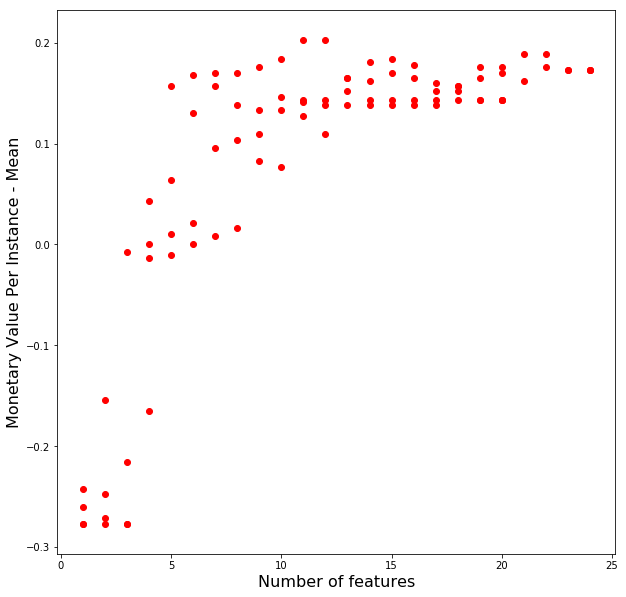

In [33]:
plt.scatter(sub_table["Feature Count"][sub_table['Data Preparation'] == 'No Scaling'],
            sub_table["Monetary Value Per Instance - Mean"][sub_table['Data Preparation'] == 'No Scaling'],
             c = 'red'),


plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [34]:
best_model = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
['totalScanTimeInSeconds' 'lineItemVoids' 'scansWithoutRegistration'
 'scannedLineItems' 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerSecond' 'secondsPerEuro'
 'quantityModificationsPerEuro' 'pca_axis_2' 'tsne_axis_1' 'tsne_axis_2']
{'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1,

Evaluate the result of all folds

In [35]:
cv_results = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Cross Validation Results"]

cv_results

{'mean_fit_time': array([0.05176127, 0.17922039, 0.37639284, 0.41788194, 0.53107927,
        0.43124623, 0.53995547, 0.58563333, 0.65215497, 0.46515551,
        0.05156207, 0.03001966, 0.03630304, 0.03021939, 0.03849692,
        0.00857692, 0.00887625, 0.00867684, 0.00837743, 0.00817816,
        0.00388982, 0.00388954, 0.00398924, 0.00398943, 0.00408914,
        0.05305781, 0.13025138, 0.26070211, 0.37200475, 0.50684397,
        0.05664833, 0.13733251, 0.28284316, 0.42685792, 0.55631158,
        0.2238013 , 0.42745624, 0.63579891, 0.76854389, 0.83436768,
        0.01775234, 0.02084413, 0.01954746, 0.02044542, 0.01904898,
        0.0083775 , 0.00837781, 0.00847726, 0.00867701, 0.00847745,
        0.00438793, 0.00379004, 0.00398951, 0.00428848, 0.00388985,
        0.05794473, 0.1394269 , 0.27626092, 0.41219726, 0.48609936]),
 'std_fit_time': array([9.40901125e-04, 2.50170806e-02, 2.28700204e-02, 4.19922823e-02,
        3.47930316e-02, 1.86712771e-01, 4.21240503e-01, 3.95744058e-01,
     

Performance of the model on the entire train data set (when trained on the entire train data set)

In [36]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
    
Y = train['fraud']
X = train.drop('fraud',axis=1)
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set


# Predictions on the entire test data set

In [37]:
test

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  valuePerSecond  lineItemVoidsPerPosition  scannedLineItems  pricePerScannedLineItem  scansWithoutRegistrationPerScannedLineItem  quantityModificationsPerScannedLineItem  lineItemVoidsPerSecond  scansWithoutRegistrationPerSecond  quantityModificationsPerSecond  secondsPerEuro  lineItemVoidsPerEuro  scansWithoutRegistrationPerEuro  quantityModificationsPerEuro  pca_axis_1  pca_axis_2  tsne_axis_1  tsne_axis_2
0                4                     467       88.48              4                         8                      4                   0.014989        0.189465                  0.571429               7.0                12.640000                                    1.142857                                 0.571429                0.008565                           0.017131                        0.008565        5.278029              0.045208                         0.090416                      0.045208    0.407059    0.107610     1.288056     0.439125
1                3                    1004       58.99              7                         6                      1                   0.026892        0.058755                  0.259259              27.0                 2.184815                                    0.222222                                 0.037037                0.006972                           0.005976                        0.000996       17.019834              0.118664                         0.101712                      0.016952   -0.404056   -0.107318    -2.048066    -0.496164
2                1                     162       14.00              4                         5                      4                   0.006173        0.086420                  4.000000               1.0                14.000000                                    5.000000                                 4.000000                0.024691                           0.030864                        0.024691       11.571429              0.285714                         0.357143                      0.285714    0.648069   -0.481068     3.447044     0.053117
3                5                     532       84.79              9                         3                      4                   0.026316        0.159380                  0.642857              14.0                 6.056429                                    0.214286                                 0.285714                0.016917                           0.005639                        0.007519        6.274325              0.106145                         0.035382                      0.047175    0.292492    0.294786     1.344228     1.554838
4                5                     890       42.16              4                         0                      0                   0.021348        0.047371                  0.210526              19.0                 2.218947                                    0.000000                                 0.000000                0.004494                           0.000000                        0.000000       21.110057              0.094877                         0.000000                      0.000000   -0.564485    0.295128    -2.414502     1.547169
5                5                    1072       12.67              3                         4                      1                   0.019590        0.011819                  0.142857              21.0                 0.603333                                    0.190476                                 0.047619                0.002799                           0.003731                        0.000933       84.609313              0.236780                         0.315706                      0.078927   -0.388592    0.294494    -1.828019     1.732591
6                3                     259       93.75              0                         7       

In [38]:
predictions = best_model.predict(test[best_model_features])

In [39]:
len(predictions)

498121

In [40]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [41]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = ['fraud']
predictions_df

fraud
0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
30          0
31          0
32          0
33          0
34          0
35          0
36          0
37          0
38          0
39          0
40          0
41          0
42          0
43          0
44          0
45          0
46          0
47          0
48          0
49          0
50          0
51          0
52          0
53          0
54          0
55          0
56          0
57          0
58          0
59          0
60          0
61          0
62          0
63          0
64          0
65          0
66          0
67          0
68          0
69          0
70          0
71          0
72          0
73          0
74          0
75          0
76          0
77          1
78          0
79          0
80          1
81          0
82          0
83          0
84          0
85          0
86          0
87          0
88          0
89          0
90          0
91          0
92          0
93          0
94          0
95          0
96          0
97          0
98          0
99          0
100         0
101         0
102         0
103         0
104         0
105         0
106         0
107         0
108         0
109         0
110         1
111         0
112         0
113         0
114         0
115         0
116         0
117         0
118         0
119         0
120         0
121         0
122         0
123         0
124         0
125         0
126         0
127         0
128         0
129         0
130         0
131         0
132         0
133         0
134         0
135         0
136         0
137         0
138         0
139         0
140         0
141         0
142         0
143         0
144         0
145         0
146         0
147         0
148         0
149         0
150         0
151         0
152         0
153         0
154         0
155         0
156         0
157         0
158         0
159         0
160         1
161         0
162         0
163         0
164         0
165         0
166         0
167         0
168         0
169         0
170         0
171         0
172         0
173         0
174         0
175         0
176         0
177         0
178         0
179         0
180         0
181         0
182         0
183         0
184         0
185         0
186         0
187         0
188         0
189         0
190         0
191         0
192         0
193         0
194         0
195         0
196         0
197         0
198         0
199         0
200         0
201         0
202         0
203         0
204         0
205         0
206         0
207         0
208         0
209         0
210         0
211         0
212         0
213         0
214         0
215         0
216         0
217         0
218         0
219         0
220         0
221         0
222         0
223         0
224         0
225         0
226         0
227         0
228         0
229         0
230         0
231         0
232         0
233         0
234         0
235         0
236         0
237         0
238         0
239         0
240         0
241         0
242         0
243         0
244         0
245         0
246         0
247         0
248         0
249         0
...       ...
497871      0
497872      0
497873      0
497874      0
497875      0
497876      0
497877      0
497878      0
497879      0
497880      0
497881      0
497882      0
497883      1
497884      0
497885      0
497886      0
497887      0
497888      0
497889      0
497890      0
497891      0
497892      0
497893      0
497894      0
497895      0
497896      0
497897      0
497898      0
497899      0
497900      0
497901      0
497902      1
497903      0
497904      0
4979

In [42]:
print(predictions_df.fraud.value_counts())
print(predictions_df.fraud.value_counts() / len(predictions_df))

0    475226
1     22895
Name: fraud, dtype: int64
0    0.954037
1    0.045963
Name: fraud, dtype: float64


# Relying on just one model yields the high risk of overfitting, therefore we create a combination of models for our final prediction

# Creating a voting classifier out of the 5 best models

In [43]:
result_table_aggregated = result_table_aggregated.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

result_table_aggregated

Model Oversampling Strategy Data Preparation Feature Count Feature Selection Technique                                           Features                                 Optimal Parameters  Monetary Value Per Instance - Mean  Monetary Value Per Instance - Standard Deviation                                          Raw Model
12             AdaBoostClassifier       No Oversampling       No Scaling            11                         RFE  [totalScanTimeInSeconds, lineItemVoids, scansW...  {'algorithm': 'SAMME.R', 'base_estimator': Dec...                            0.202235                                          0.038051  (DecisionTreeClassifier(class_weight=None, cri...
3                   XGBClassifier       No Oversampling       No Scaling            22                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'base_score': 0.5, 'eval_metric': 'error', 'l...                            0.175625                                          0.108912  XGBClassifier(base_score=0.5, booster='gbtree'...
4              LogisticRegression       No Oversampling       No Scaling             9                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'C': 1.2000000000000002, 'fit_intercept': Tru...                            0.167642                                          0.118947  LogisticRegression(C=1.2000000000000002, class...
2            ExtraTreesClassifier       No Oversampling       No Scaling             8                         RFE  [trustLevel, totalScanTimeInSeconds, lineItemV...      {'criterion': 'entropy', 'n_estimators': 140}                            0.146354                                          0.077010  (ExtraTreeClassifier(class_weight=None, criter...
5      GradientBoostingClassifier       No Oversampling       No Scaling            10                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...          {'loss': 'deviance', 'n_estimators': 150}                            0.143693                                          0.101174  ([DecisionTreeRegressor(criterion='friedman_ms...
15              BaggingClassifier       No Oversampling       No Scaling            14                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'base_estimator': LogisticRegression(C=1.0, c...                            0.138371                                          0.091208  (LogisticRegression(C=1.0, class_weight=None, ...
6          RandomForestClassifier       No Oversampling   StandardScaler            10                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...      {'criterion': 'entropy', 'n_estimators': 105}                            0.101118                                          0.089369  (DecisionTreeClassifier(class_weight=None, cri...
11         DecisionTreeClassifier       No Oversampling     MinMaxScaler            14                 SelectKBest  [trustLevel, totalScanTimeInSeconds, lineItemV...  {'criterion': 'gini', 'max_depth': 35, 'min_sa...                            0.085152                                          0.094774  DecisionTreeClassifier(class_weight=None, crit...
14                  MLPClassifier       No Oversampling   StandardScaler            20                 SelectKBest  [trustLevel, totalScanTimeInSeconds, grandTota...  {'activation': 'logistic', 'learning_rate': 'c...                            0.077169                                          0.071634  MLPClassifier(activation='logistic', alpha=0.0...
8             ExtraTreeClassifier       No Oversampling        LogScaler             5                         RFE  [totalScanTimeInSeconds, scansWithoutRegistrat...  {'criterion': 'gini', 'max_depth': 21, 'min_sa...                            0.055881                                          0.115128  ExtraTreeClassifier(class_weight=None, criteri...
0                      GaussianNB       No Oversampling       No Scaling             3                 SelectKBest  [trustLevel, total

# Best Model

In [44]:
model1 = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
model1_features = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Features"]
model1_parameters = result_table.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(model1)
print(model1_features)
print(model1_parameters)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
['totalScanTimeInSeconds' 'lineItemVoids' 'scansWithoutRegistration'
 'scannedLineItems' 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerSecond' 'secondsPerEuro'
 'quantityModificationsPerEuro' 'pca_axis_2' 'tsne_axis_1' 'tsne_axis_2']
{'C': 1.2000000000000002, 'fit_intercept': False, 'solver': 'liblinear'}


# Second Best Model

In [45]:
model2 = result_table_aggregated[1:].loc[result_table_aggregated[1:]["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
model2_features = result_table_aggregated[1:].loc[result_table_aggregated[1:]["Monetary Value Per Instance - Mean"].argmax()]["Features"]
model2_parameters = result_table_aggregated[1:].loc[result_table_aggregated[1:]["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(model2)
print(model2_features)
print(model2_parameters)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='error', gamma=0, learning_rate=0.3,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'scannedLineItemsPerSecond' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem' 'lineItemVoidsPerSecond'
 'scansWithoutRegistrationPerSecond' 'quantityModificationsPerSecond'
 'secondsPerEuro' 'lineItemVoidsPerEuro' 'scansWithoutRegistrationPerEuro'
 'quantityModificationsPerEuro' 'pca_axis_1' 'pca_axis_2' 'tsne_axis_1'
 'tsne_axis_2']
{'base_score': 0.5, 'eval_metric': 'e

# Third Best Model

In [46]:
model3 = result_table_aggregated[2:].loc[result_table_aggregated[2:]["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
model3_features = result_table_aggregated[2:].loc[result_table_aggregated[2:]["Monetary Value Per Instance - Mean"].argmax()]["Features"]
model3_parameters = result_table_aggregated[2:].loc[result_table_aggregated[2:]["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(model3)
print(model3_features)
print(model3_parameters)

LogisticRegression(C=1.2000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'lineItemVoidsPerPosition' 'scannedLineItems'
 'pricePerScannedLineItem' 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem']
{'C': 1.2000000000000002, 'fit_intercept': True, 'solver': 'newton-cg'}


# Fourth Best Model

In [47]:
model4 = result_table_aggregated[3:].loc[result_table_aggregated[3:]["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
model4_features = result_table_aggregated[3:].loc[result_table_aggregated[3:]["Monetary Value Per Instance - Mean"].argmax()]["Features"]
model4_parameters = result_table_aggregated[3:].loc[result_table_aggregated[3:]["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(model4)
print(model4_features)
print(model4_parameters)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'scannedLineItemsPerSecond' 'valuePerSecond'
 'scannedLineItems' 'scansWithoutRegistrationPerScannedLineItem']
{'criterion': 'entropy', 'n_estimators': 140}


# Fifth Best Model

In [48]:
model5 = result_table_aggregated[4:].loc[result_table_aggregated[4:]["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
model5_features = result_table_aggregated[4:].loc[result_table_aggregated[4:]["Monetary Value Per Instance - Mean"].argmax()]["Features"]
model5_parameters = result_table_aggregated[4:].loc[result_table_aggregated[4:]["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(model5)
print(model5_features)
print(model5_parameters)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'valuePerSecond' 'lineItemVoidsPerPosition'
 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem']
{'loss': 'deviance', 'n_estimators': 150}


predicting the train set

In [49]:
model_1_train_predictions = model1.predict(train[model1_features])
model_2_train_predictions = model2.predict(train[model2_features])
model_3_train_predictions = model3.predict(train[model3_features])
model_4_train_predictions = model4.predict(train[model4_features])
model_5_train_predictions = model5.predict(train[model5_features])

In [50]:
import statistics

train_predictions = pd.DataFrame({ 'Model_1_Prediction': model_1_train_predictions,
                                   'Model_2_Prediction': model_2_train_predictions,
                                   'Model_3_Prediction': model_3_train_predictions,
                                   'Model_4_Prediction': model_4_train_predictions,
                                   'Model_5_Prediction': model_5_train_predictions
                                 })

train_predictions['Voting_Prediction'] = train_predictions.apply(statistics.mode, axis = 1)

In [51]:
train_predictions

Model_1_Prediction  Model_2_Prediction  Model_3_Prediction  Model_4_Prediction  Model_5_Prediction  Voting_Prediction
0                      0                   0                   0                   0                   0                  0
1                      0                   0                   0                   0                   0                  0
2                      0                   0                   0                   0                   0                  0
3                      0                   0                   0                   0                   0                  0
4                      0                   0                   0                   0                   0                  0
5                      1                   1                   1                   1                   1                  1
6                      0                   0                   0                   0                   0                  0
7                      0                   0                   0                   0                   0                  0
8                      0                   0                   0                   0                   0                  0
9                      0                   0                   0                   0                   0                  0
10                     0                   0                   0                   0                   0                  0
11                     0                   0                   0                   0                   0                  0
12                     0                   0                   0                   0                   0                  0
13                     0                   0                   0                   0                   0                  0
14                     0                   0                   0                   0                   0                  0
15                     0                   0                   0                   0                   0                  0
16                     0                   0                   0                   0                   0                  0
17                     0                   0                   0                   0                   0                  0
18                     0                   0                   0                   0                   0                  0
19                     0                   0                   0                   0                   0                  0
20                     0                   0                   0                   0                   0                  0
21                     0                   0                   0                   0                   0                  0
22                     0                   0                   0                   0                   0                  0
23                     0                   0                   0                   0                   0                  0
24                     0                   0                   0                   0                   0                  0
25                     0                   0                   0                   0                   0                  0
26                     0                   0                   0                   0                   0                  0
27                     0                   0                   0                   0                   0                  0
28                     0                   0                   0                   0                   0                  0
29                     0                   0                   0                   0                   0                  0
30                     0                   0                   0                   0                   0                  0
31                     0              

Resulting Confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(train['fraud'], train_predictions['Voting_Prediction'].values)

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set


predict the test set

In [53]:
model_1_test_predictions = model1.predict(test[model1_features])
model_2_test_predictions = model2.predict(test[model2_features])
model_3_test_predictions = model3.predict(test[model3_features])
model_4_test_predictions = model4.predict(test[model4_features])
model_5_test_predictions = model5.predict(test[model5_features])

In [54]:
import statistics

test_predictions = pd.DataFrame({ 'AdaBoost_Prediction': model_1_test_predictions,
                                  'XGBClassifier_Prediction': model_2_test_predictions,
                                  'LogisticRegression_Prediction': model_3_test_predictions,
                                  'ExtraTreesClassifier_Prediction': model_4_test_predictions,
                                  'GradientBoostingClassifier_Prediction': model_5_test_predictions
                                })

test_predictions['Voting_Prediction'] = test_predictions.apply(statistics.mode, axis = 1)

In [37]:
test_predictions

AdaBoost_Prediction  XGBClassifier_Prediction  LogisticRegression_Prediction  ExtraTreesClassifier_Prediction  GradientBoostingClassifier_Prediction  Voting_Prediction
0                         0                         0                              0                                0                                      0                  0
1                         0                         0                              0                                0                                      0                  0
2                         0                         0                              0                                0                                      0                  0
3                         0                         0                              0                                0                                      0                  0
4                         0                         0                              0                                0                                      0                  0
5                         0                         0                              0                                0                                      0                  0
6                         0                         0                              0                                0                                      0                  0
7                         0                         0                              0                                0                                      0                  0
8                         0                         0                              0                                0                                      0                  0
9                         0                         0                              0                                0                                      0                  0
10                        0                         0                              0                                0                                      0                  0
11                        0                         0                              0                                0                                      0                  0
12                        0                         0                              0                                0                                      0                  0
13                        0                         0                              0                                0                                      0                  0
14                        0                         0                              0                                0                                      0                  0
15                        0                         0                              0                                0                                      0                  0
16                        0                         0                              0                                0                                      0                  0
17                        0                         0                              0                                0                                      0                  0
18                        0                         0                              0                                0                                      0                  0
19                        0                         0                              0                                0                                      0                  0
20                        0                         0                              0                                0                                      0                  0
21                        0                         0                              0                                0                   

In [55]:
#test_predictions.corr

import matplotlib.pyplot as plt

corr = test_predictions.corr()

corr

AdaBoost_Prediction  XGBClassifier_Prediction  LogisticRegression_Prediction  ExtraTreesClassifier_Prediction  GradientBoostingClassifier_Prediction  Voting_Prediction
AdaBoost_Prediction                               1.000000                  0.880626                       0.839460                         0.825980                               0.840932           0.901818
XGBClassifier_Prediction                          0.880626                  1.000000                       0.844367                         0.858882                               0.872015           0.931536
LogisticRegression_Prediction                     0.839460                  0.844367                       1.000000                         0.828866                               0.843586           0.893199
ExtraTreesClassifier_Prediction                   0.825980                  0.858882                       0.828866                         1.000000                               0.885793           0.909879
GradientBoostingClassifier_Prediction             0.840932                  0.872015                       0.843586                         0.885793                               1.000000           0.923780
Voting_Prediction                                 0.901818                  0.931536                       0.893199                         0.909879                               0.923780           1.000000

In [56]:
test_prediction_values = test_predictions['Voting_Prediction'].values

test_prediction_values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [58]:
predictions_df = pd.DataFrame(test_prediction_values)
predictions_df.columns = ['fraud']
predictions_df

fraud
0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
30          0
31          0
32          0
33          0
34          0
35          0
36          0
37          0
38          0
39          0
40          0
41          0
42          0
43          0
44          0
45          0
46          0
47          0
48          0
49          0
50          0
51          0
52          0
53          0
54          0
55          0
56          0
57          0
58          0
59          0
60          0
61          0
62          0
63          0
64          0
65          0
66          0
67          0
68          0
69          0
70          0
71          0
72          0
73          0
74          0
75          0
76          0
77          0
78          0
79          0
80          1
81          0
82          0
83          0
84          0
85          0
86          0
87          0
88          0
89          0
90          0
91          0
92          0
93          0
94          0
95          0
96          0
97          0
98          0
99          0
100         0
101         0
102         0
103         0
104         0
105         0
106         0
107         0
108         0
109         0
110         1
111         0
112         0
113         0
114         0
115         0
116         0
117         0
118         0
119         0
120         0
121         0
122         0
123         0
124         0
125         0
126         0
127         0
128         0
129         0
130         0
131         0
132         0
133         0
134         0
135         0
136         0
137         0
138         0
139         0
140         0
141         0
142         0
143         0
144         0
145         0
146         0
147         0
148         0
149         0
150         0
151         0
152         0
153         0
154         0
155         0
156         0
157         0
158         0
159         0
160         1
161         0
162         0
163         0
164         0
165         0
166         0
167         0
168         0
169         0
170         0
171         0
172         0
173         0
174         0
175         0
176         0
177         0
178         0
179         0
180         0
181         0
182         0
183         0
184         0
185         0
186         0
187         0
188         0
189         0
190         0
191         0
192         0
193         0
194         0
195         0
196         0
197         0
198         0
199         0
200         0
201         0
202         0
203         0
204         0
205         0
206         0
207         0
208         0
209         0
210         0
211         0
212         0
213         0
214         0
215         0
216         0
217         0
218         0
219         0
220         0
221         0
222         0
223         0
224         0
225         0
226         0
227         0
228         0
229         0
230         0
231         0
232         0
233         0
234         0
235         0
236         0
237         0
238         0
239         0
240         0
241         0
242         0
243         0
244         0
245         0
246         0
247         0
248         0
249         0
...       ...
497871      0
497872      0
497873      0
497874      0
497875      0
497876      0
497877      0
497878      0
497879      0
497880      0
497881      0
497882      0
497883      1
497884      0
497885      0
497886      0
497887      0
497888      0
497889      0
497890      0
497891      0
497892      0
497893      0
497894      0
497895      0
497896      0
497897      0
497898      0
497899      0
497900      0
497901      0
497902      1
497903      0
497904      0
4979

In [59]:
print(predictions_df.fraud.value_counts())
print(predictions_df.fraud.value_counts() / len(predictions_df))

0    476416
1     21705
Name: fraud, dtype: int64
0    0.956426
1    0.043574
Name: fraud, dtype: float64


# Exporting the final prediction

In [60]:
predictions_df.to_csv('submission/TU_Muenchen_2.csv', index = False)